In [1]:
import numpy as np
import os

os.environ["KERAS_BACKEND"] = "tensorflow"

import keras

2025-08-25 23:26:32.654104: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-08-25 23:26:32.654320: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-08-25 23:26:32.750088: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-08-25 23:26:32.949600: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-08-25 23:26:35.108500: W tensorflow/compiler/tf2

In [10]:
%load_ext tensorboard

In [ ]:
import tensorflow as tf

In [2]:
import pandas as pd

df = pd.read_csv('nn_dataset.csv')
print(f'loaded {len(df)} items')

loaded 4105 items


In [3]:
from sklearn.model_selection import train_test_split

THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]
limited_data_columns = [
    'Max NPS', 'Log Length',
    *(f'N_{x}' for x in THRESHOLDS), # avg nps per bin
    *(f'T_{x}' for x in THRESHOLDS), # threshold counts
    *(f'PS_{x}' for x in THRESHOLDS), # percent stream
    # *(f'B_{x}_{b}' for x in THRESHOLDS for b in BREAK_LENGTHS)
]
X_all, y_all = df[limited_data_columns], df['Meter']
X_train, X_test, y_train, y_test = train_test_split(
    X_all, y_all, test_size=0.2, random_state=4, stratify=y_all
)

# train_set, test_set = torch.utils.data.random_split(all_data, [.8, .2], generator=torch.Generator(device=device).manual_seed(2024))

print(f"train examples = {len(X_train)}, validation examples = {len(X_test)}")
print(X_train.shape)
print(4103 in X_train.index, 4100 in X_train.index)

train examples = 3284, validation examples = 821
(3284, 17)
True True


In [ ]:
from keras.layers import Input, Dense
from airt.keras.layers import MonoDense
from keras.optimizers import Adam, AdamW, SGD
from keras.optimizers.schedules import ExponentialDecay
#from keras import ops
from keras import backend as K
import datetime
import keras_tuner

@keras.saving.register_keras_serializable()
def acc(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

# normalization_layer = keras.layers.Normalization()
# normalization_layer.adapt(X_train.to_numpy())

# lr_schedule = ExponentialDecay(
#     initial_learning_rate=1e-3,
#     decay_steps=len(X_train) // 64 * 2,
#     decay_rate=0.99,
# )

def build_model(
    units,
    n_layers,
    activation,
    lr
):
    model = keras.Sequential()
    act_weights = (1.0, 1.0, 1.0)
    for _ in range(n_layers):
        model.add(MonoDense(
            units, activation=activation, activation_weights=act_weights
        ))
    model.add(MonoDense(1, activation_weights=act_weights))

    optimizer = Adam(learning_rate=lr)
    model.compile(
        optimizer=optimizer,
        loss="mse",
        metrics=[acc]
    )
    return model

def build_model_with_hp(hp: keras_tuner.HyperParameters):
    return build_model(
        units=hp.Choice('units', [64, 128, 192, 256, 384, 512]),
        n_layers=hp.Int('n_layers', min_value=1, max_value=4, step=1),
        activation=hp.Choice('activation', ['relu', 'elu']),
        lr=hp.Float('lr', min_value=1e-5, max_value=1e-1, sampling='log')
    )

In [5]:
tuner = keras_tuner.Hyperband(
    hypermodel=build_model_with_hp,
    objective='val_loss',
    max_epochs=900,
    factor=3,
    # max_trials=10,
    # executions_per_trial=1,
    overwrite=False,
    directory='tuner',
    project_name='hyperband_test'
)

Reloading Tuner from tuner/hyperband_test/tuner0.json


In [10]:
tuner.search_space_summary()

Search space summary
Default search space size: 4
units (Choice)
{'default': 64, 'conditions': [], 'values': [64, 128, 192, 256, 384, 512], 'ordered': True}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
activation (Choice)
{'default': 'relu', 'conditions': [], 'values': ['relu', 'elu'], 'ordered': False}
lr (Float)
{'default': 1e-05, 'conditions': [], 'min_value': 1e-05, 'max_value': 0.1, 'step': None, 'sampling': 'log'}


In [6]:
callbacks = [
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=60),
]
tuner.search(
    X_train, y_train, batch_size=64, epochs=900,
    validation_data=(X_test, y_test),
    callbacks=callbacks
)

Trial 2074 Complete [00h 30m 27s]
val_loss: 0.28641077876091003

Best val_loss So Far: 0.27363836765289307
Total elapsed time: 21h 24m 52s


In [7]:
tuner.results_summary()

Results summary
Results in tuner/hyperband_test
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 2068 summary
Hyperparameters:
units: 192
n_layers: 4
activation: elu
lr: 0.00040906852217169077
tuner/epochs: 900
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.27363836765289307

Trial 2009 summary
Hyperparameters:
units: 384
n_layers: 1
activation: elu
lr: 0.01957107498578762
tuner/epochs: 300
tuner/initial_epoch: 100
tuner/bracket: 3
tuner/round: 2
tuner/trial_id: 2003
Score: 0.2835453152656555

Trial 2073 summary
Hyperparameters:
units: 512
n_layers: 2
activation: elu
lr: 0.0007465408945491774
tuner/epochs: 900
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.28641077876091003

Trial 1932 summary
Hyperparameters:
units: 192
n_layers: 2
activation: elu
lr: 0.017651327086753286
tuner/epochs: 300
tuner/initial_epoch: 100
tuner/bracket: 4
tuner/round: 3
tuner/trial_id: 1923
Score: 0.29456865787506104

Trial 2047 summary
Hyperparameter

In [ ]:
from livelossplot import PlotLossesKeras

plotlosses = PlotLossesKeras()

In [23]:
#model = build_model_with_hp(tuner.get_best_hyperparameters(2)[1])
model = build_model(
    384, 1, 'elu',
    keras.optimizers.schedules.CosineDecay(
        0.006, len(X_train) // 64 * 900, alpha=0.01
    )
)

In [37]:
#model = keras.models.load_model('checkpoints/tb/0825-030645_mono_relu_test_best.keras')
model.load_weights(f'checkpoints/tb/{test_name}_best.ckpt')

In [24]:
from keras.optimizers import Adam
from keras.optimizers.schedules import ExponentialDecay
#from keras import ops
from keras import backend as K
import datetime

now = datetime.datetime.now().strftime("%m%d-%H%M%S")
test_name = now + '_schedule_test2'
print(test_name)
log_dir = "logs/fit/" + test_name
callbacks = [
    keras.callbacks.ModelCheckpoint(
        filepath=f"checkpoints/tb/{test_name}_best.ckpt",
        monitor='val_acc',
        verbose=1,
        save_best_only=True,
        save_weights_only=True,
        mode='max'
    ),
    # keras.callbacks.EarlyStopping(monitor="val_loss", patience=100),
    keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1),
]

history = model.fit(
    x=X_train, y=y_train, batch_size=64, validation_data=(X_test, y_test), epochs=900, callbacks=callbacks,
    initial_epoch=0
)

0826-171652_schedule_test2
Epoch 1/900
50/52 [===========================>..] - ETA: 0s - loss: 176.8864 - acc: 0.0425
Epoch 1: val_acc improved from -inf to 0.08468, saving model to checkpoints/tb/0826-171652_schedule_test2_best.ckpt
52/52 [==============================] - 2s 22ms/step - loss: 172.5844 - acc: 0.0427 - val_loss: 7.4761 - val_acc: 0.0847
Epoch 2/900
48/52 [==========================>...] - ETA: 0s - loss: 3.7776 - acc: 0.2158
Epoch 2: val_acc improved from 0.08468 to 0.30497, saving model to checkpoints/tb/0826-171652_schedule_test2_best.ckpt
52/52 [==============================] - 1s 17ms/step - loss: 3.6856 - acc: 0.2273 - val_loss: 2.4379 - val_acc: 0.3050
Epoch 3/900
52/52 [==============================] - ETA: 0s - loss: 1.9437 - acc: 0.3147
Epoch 3: val_acc improved from 0.30497 to 0.30667, saving model to checkpoints/tb/0826-171652_schedule_test2_best.ckpt
52/52 [==============================] - 1s 17ms/step - loss: 1.9437 - acc: 0.3147 - val_loss: 1.9032 - v

In [36]:
model.save_weights(f"checkpoints/tb/{test_name}_900.ckpt")

In [ ]:
keras.optimizers.schedules

In [ ]:
import matplotlib.pyplot as plt
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'], alpha=0.3)
plt.xlabel('epoch')
plt.ylabel('acc')
plt.grid()

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'], alpha=0.3)
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1])
plt.grid()

26/26 [==============================] - 0s 6ms/step
correct: 0.6918392204628502 / 821
mae: [0.40372962] / 821


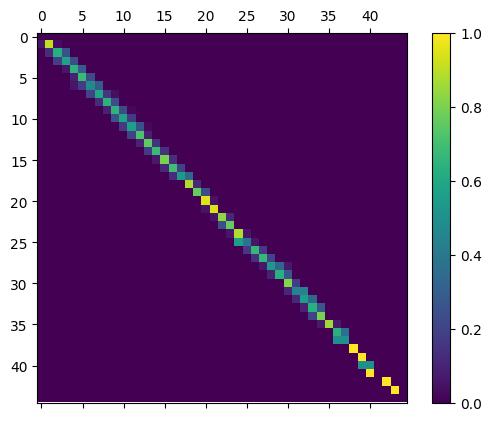

In [38]:
import matplotlib.pyplot as plt

def display_confusion(X, y):
    width = 43-1+3
    confusion = np.zeros((width, width))

    preds = model.predict(X.to_numpy())
    ys = y

    correct_count = 0
    cum_err = 0
    for pred, true_meter in zip(preds, ys):
        pred = pred
        guess_meter = round(pred[0])
        guess_meter = max(0, min(44, guess_meter))

        cum_err += abs(pred - true_meter)
        
        if true_meter == guess_meter:
            correct_count += 1
        true_meter = max(0, min(44, true_meter))
        confusion[int(true_meter)][int(guess_meter)] += 1
    
    correct_count = (preds.squeeze().round() == y).sum()
    print(f"correct: {correct_count / len(ys)} / {len(ys)}")
    print(f"mae: {cum_err / len(ys)} / {len(ys)}")

    # Normalize by dividing every row by its sum
    for i in range(width):
        denom = confusion[i].sum()
        if denom > 0:
            confusion[i] = confusion[i] / denom

    # Set up plot
    fig = plt.figure()
    ax = fig.add_subplot(111)
    cax = ax.matshow(confusion) #numpy uses cpu here so we need to use a cpu version
    fig.colorbar(cax)

    # Set up axes
    # ax.set_xticks(np.arange(width))
    # ax.set_yticks(np.arange(width))
    #ax.tick_params(axis='both', labelsize=5)
    #ax.tick_params(axis='x', labelrotation=90)

    # Force label at every tick
    # ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    # ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    # sphinx_gallery_thumbnail_number = 2
    plt.show()

display_confusion(X_test, y_test)

In [28]:
from bokeh.plotting import figure, show, output_notebook
from bokeh.models import HoverTool, ColumnDataSource, LinearColorMapper
from bokeh import palettes

output_notebook()

Loading BokehJS ...

In [42]:
from bokeh.models.tickers import BasicTicker
def bokeh_display(X, y, names_df=None, palette=palettes.Turbo256):
    if names_df is None:
        names_df = df
    preds = model.predict(X.to_numpy())
    correct_count = 0
    cum_err = 0
    for pred, true_meter in zip(preds, y):
        guess_meter = round(pred[0])
        cum_err += abs(pred - true_meter)        
        if true_meter == guess_meter:
            correct_count += 1
    print(f"correct: {correct_count / len(y)} / {len(y)}")
    print(f"mae: {cum_err / len(y)} / {len(y)}")

    disp_df = pd.DataFrame(index=y.index)
    disp_df['y'] = preds
    disp_df['x'] = y
    disp_df.set_index
    disp_df = disp_df.merge(names_df[['Name', 'Meter']], left_index=True, right_index=True)

    datasource = ColumnDataSource(disp_df)
    color_mapping = LinearColorMapper(
        palette=palette
    )

    plot_figure = figure(
        width=500,
        height=500,
        tools=('pan, wheel_zoom, reset')
    )

    hvr = HoverTool(tooltips="""
    <div>
        <div>
            <span style='font-size: 12px; color: #224499'>[@Meter]</span>
            <span style='font-size: 12px; color: #994422'>[@y]</span>
            <span style='font-size: 12px'>@Name</span>
        </div>
    </div>
    """)
    plot_figure.add_tools(hvr)

    scatter = plot_figure.scatter(
        'x',
        'y',
        source=datasource,
        color=dict(field='Meter', transform=color_mapping),
        line_alpha=0,
        fill_alpha=0.5,
        size=8
    )
    hvr.renderers = [scatter]
    line_vals = np.arange(min(y), max(y)+1)
    plot_figure.line(x=line_vals, y=line_vals)
    plot_figure.ygrid.ticker = BasicTicker(min_interval=1, max_interval=1)
    show(plot_figure)

bokeh_display(X_test, y_test, palette=palettes.Turbo256*2)

26/26 [==============================] - 0s 7ms/step
correct: 0.6918392204628502 / 821
mae: [0.40372962] / 821


In [31]:
import math
from fractions import Fraction

def get_block_repr(bpm, measures):
    THRESHOLDS = [0, 0.2, 0.4, 0.6, 0.8]
    BREAK_LENGTHS = [0, 1, 2, 4, 8, 16]

    nps = bpm * 4 / 60
    measure_len = 60 / bpm * 4
    max_nps = nps #math.ceil(nps)
    max_nps_lower = max_nps - 1
    length_secs = measure_len * measures
    length = length_secs * 2

    prop_higher = nps % 1 if nps < max_nps else 1
    prop_lower = 1 - prop_higher
    lower_bin_i = -1
    for thresh in THRESHOLDS:
        if max_nps_lower > thresh * max_nps:
            lower_bin_i += 1
        else:
            break
    
    avg_nps_per_bin = [(t+0.1) * max_nps for t in THRESHOLDS]
    nps_vals_are_in_same_bin = lower_bin_i == len(THRESHOLDS) - 1 or nps == max_nps
    if nps_vals_are_in_same_bin:
        avg_nps_per_bin[-1] = nps
    else:
        avg_nps_per_bin[-1] = max_nps
        if lower_bin_i > -1:
            avg_nps_per_bin[lower_bin_i] = max_nps_lower
    
    threshold_counts = [length for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        for i in range(lower_bin_i+1, len(THRESHOLDS)):
            threshold_counts[i] = length * prop_higher
    
    density_per_bin = [1 for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        for i in range(lower_bin_i+1, len(THRESHOLDS)):
            threshold_counts[i] = prop_higher    

    # longest continuous block of NPS >= threshold
    # allowing for different lengths of break
    longest_blocks = [[length for _ in BREAK_LENGTHS] for _ in THRESHOLDS]
    if not nps_vals_are_in_same_bin:
        #print(nps, lower_bin_i, prop_higher, prop_lower)
        ratio_higher_to_lower = prop_higher / prop_lower
        if ratio_higher_to_lower > 1:
            block_len = math.ceil(ratio_higher_to_lower)
            break_len = 1
        else:
            block_len = 1
            break_len = math.ceil(1 / ratio_higher_to_lower)
        for thresh_i in range(lower_bin_i+1, len(THRESHOLDS)):
            for break_i, max_break_len in enumerate(BREAK_LENGTHS):
                if break_len > max_break_len:
                    longest_blocks[thresh_i][break_i] = block_len

    return [
        max_nps,
        math.log2(length+1),
        # avg_nps_per_bin,
        # threshold_counts,
        # density_per_bin,
        # longest_blocks
        *avg_nps_per_bin,
        *(math.log2(x+1) for x in threshold_counts),
        *density_per_bin
        #*(math.log2(x+1) for row in longest_blocks for x in row)
    ]

In [32]:
inp = get_block_repr(510, 64)
#print(inp)
model.predict([inp])

1/1 [==============================] - 0s 69ms/step


array([[44.14651]], dtype=float32)

In [33]:
inp = [get_block_repr(bpm, 32) for bpm in range(10, 520, 10)]
#print(inp)
out = model.predict(inp)
for i, r in enumerate(out):
    print(10+i*10, r+0.5)

2/2 [==============================] - 0s 7ms/step
10 [3.0180976]
20 [3.5362642]
30 [4.4764347]
40 [5.5715213]
50 [6.4378405]
60 [7.1888733]
70 [8.02314]
80 [8.77183]
90 [9.482479]
100 [10.130984]
110 [10.6118145]
120 [11.025794]
130 [11.438071]
140 [11.876951]
150 [12.346694]
160 [12.847505]
170 [13.388758]
180 [13.98076]
190 [14.634576]
200 [15.359837]
210 [16.157204]
220 [17.033674]
230 [17.998335]
240 [19.049562]
250 [20.103882]
260 [21.12291]
270 [22.109005]
280 [23.068035]
290 [24.004892]
300 [24.923681]
310 [25.827723]
320 [26.719782]
330 [27.60209]
340 [28.476545]
350 [29.344687]
360 [30.207787]
370 [31.06689]
380 [31.922873]
390 [32.776436]
400 [33.628162]
410 [34.478542]
420 [35.327946]
430 [36.17671]
440 [37.025093]
450 [37.8733]
460 [38.72151]
470 [39.56985]
480 [40.418434]
490 [41.26735]
500 [42.116642]
510 [42.96639]


In [39]:
RESOLUTION = 200
STREAM_BOUNDS = (0, 16)
BPM_BOUNDS = (10, 600)
x, y = np.meshgrid(
    np.linspace(BPM_BOUNDS[0], BPM_BOUNDS[1], RESOLUTION),
    np.linspace(STREAM_BOUNDS[0], STREAM_BOUNDS[1], RESOLUTION)
)
inp = np.reshape(np.dstack((x, y)), (-1, 2))
inp = np.asarray([get_block_repr(item[0], 2**item[1]) for item in inp])
image = model.predict(inp)
image = image.reshape((RESOLUTION, RESOLUTION))
# out = classifier.model(torch.tensor(inp, dtype=torch.float32))
# out = out.detach().numpy().reshape((RESOLUTION, RESOLUTION)).round()

1250/1250 [==============================] - 6s 5ms/step


0.37884694 64.6161


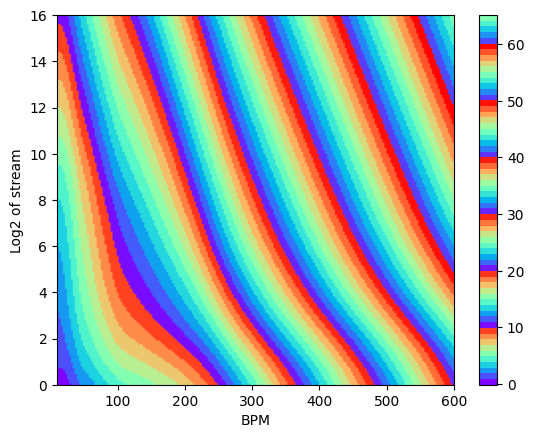

In [45]:
import matplotlib
from matplotlib.colors import ListedColormap, Normalize

vmin = np.min(image)
vmax = np.max(image)
print(vmin, vmax)
norm = Normalize(vmin=vmin-0.5, vmax=vmax+0.5)
#norm = Normalize(vmin=-0.5, vmax=70.5)
cmap = matplotlib.colormaps['rainbow']
#cmap = ListedColormap(cmap(np.linspace(0, 7, 60) % 1))
cmap = ListedColormap(cmap(np.linspace(0, round(vmax-vmin+1)/10, int(vmax-vmin+1)) % 1))
# cmap = matplotlib.colormaps['viridis']

fig = plt.figure()
ax = fig.add_subplot()

#ax.view_init(elev=90, azim=-90, roll=0)
ax.set_xlabel('BPM')
ax.set_ylabel('Log2 of stream')
#ax.set_zlabel('Density')
pos = ax.imshow(image, origin='lower', cmap=cmap, alpha=1, extent=(*BPM_BOUNDS, *STREAM_BOUNDS),
          aspect='auto', norm=norm)
fig.colorbar(pos)
plt.savefig(f"checkpoints/tb/{test_name}_best_res.png")
plt.show()

In [ ]:
model.compile(
    loss=keras.losses.SparseCategoricalCrossentropy(),
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    metrics=[
        keras.metrics.SparseCategoricalAccuracy(name="acc"),
    ],
)

In [ ]:
batch_size = 128
epochs = 20

callbacks = [
    keras.callbacks.ModelCheckpoint(filepath="model_at_epoch_{epoch}.keras"),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=2),
]

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_split=0.15,
    callbacks=callbacks,
)
score = model.evaluate(x_test, y_test, verbose=0)

In [ ]:
predictions = model.predict(x_test)


In [ ]:
predictions